In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings('ignore')

#### 1- Load the data

In [2]:
# Load dataset
df = pd.read_csv('/Users/mustafaaldabbas/Documents/GitHub/Machine_learning_superstore/df_cleaned.csv')

# Convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Display basic info and summary statistics
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   invoice_id               1000 non-null   object        
 1   branch                   1000 non-null   object        
 2   city                     1000 non-null   object        
 3   customer_type            1000 non-null   object        
 4   gender                   1000 non-null   object        
 5   product_line             1000 non-null   object        
 6   unit_price               1000 non-null   float64       
 7   quantity                 1000 non-null   int64         
 8   tax_5                    1000 non-null   float64       
 9   total                    1000 non-null   float64       
 10  date                     1000 non-null   datetime64[ns]
 11  time                     1000 non-null   object        
 12  payment                  1000 non-n

In [3]:
df

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,2024-08-05 13:08:00,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,2024-08-05 10:29:00,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,2024-08-05 13:23:00,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,2024-08-05 20:33:00,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,2024-08-05 10:37:00,Ewallet,604.17,4.761905,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,233-67-5758,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,2.0175,42.3675,2019-01-29,2024-08-05 13:46:00,Ewallet,40.35,4.761905,2.0175,6.2
996,303-96-2227,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,48.6900,1022.4900,2019-03-02,2024-08-05 17:16:00,Ewallet,973.80,4.761905,48.6900,4.4
997,727-02-1313,A,Yangon,Member,Male,Food and beverages,31.84,1,1.5920,33.4320,2019-02-09,2024-08-05 13:22:00,Cash,31.84,4.761905,1.5920,7.7
998,347-56-2442,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,3.2910,69.1110,2019-02-22,2024-08-05 15:33:00,Cash,65.82,4.761905,3.2910,4.1


### Sales over time 

In [4]:
# Convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract year, month, and day from the date column
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day


# Aggregate sales data by date
sales_by_date = df.groupby('date')['total'].sum().reset_index()

# Extract year, month, and day from the date column
sales_by_date['year'] = sales_by_date['date'].dt.year
sales_by_date['month'] = sales_by_date['date'].dt.month
sales_by_date['day'] = sales_by_date['date'].dt.day

# Display the first few rows of the aggregated sales data
sales_by_date=pd.DataFrame(sales_by_date)
sales_by_date


,date,total,year,month,day
0,2019-01-01,4745.1810,2019,1,1
1,2019-01-02,1945.5030,2019,1,2
2,2019-01-03,2078.1285,2019,1,3
3,2019-01-04,1623.6885,2019,1,4
4,2019-01-05,3536.6835,2019,1,5
...,...,...,...,...,...
84,2019-03-26,1962.5130,2019,3,26
85,2019-03-27,2902.8195,2019,3,27
86,2019-03-28,2229.4020,2019,3,28
87,2019-03-29,4023.2430,2019,3,29


In [5]:
# Aggregate additional columns by date and city separately
additional_columns = df.groupby(['date', 'branch'])
additional_columns

In [6]:
# Create a new DataFrame with the specified columns
df1 = df[['date', 'unit_price', 'quantity', 'branch', 'rating', 'day', 'month', 'year', 'total']]
# Sort the DataFrame by date in ascending order
df1 = df1.sort_values(by='date')
df1

,date,unit_price,quantity,branch,rating,day,month,year,total
856,2019-01-01,21.12,8,B,6.3,1,1,2019,177.408
567,2019-01-01,65.74,9,A,7.7,1,1,2019,621.243
245,2019-01-01,47.59,8,A,5.7,1,1,2019,399.756
696,2019-01-01,27.04,4,A,6.9,1,1,2019,113.568
523,2019-01-01,62.87,2,C,5.0,1,1,2019,132.027
...,...,...,...,...,...,...,...,...,...
158,2019-03-30,97.22,9,B,6.0,30,3,2019,918.729
881,2019-03-30,10.18,8,C,9.5,30,3,2019,85.512
963,2019-03-30,96.82,3,C,6.7,30,3,2019,304.983
937,2019-03-30,89.48,5,A,7.4,30,3,2019,469.770


### EDA Performing 

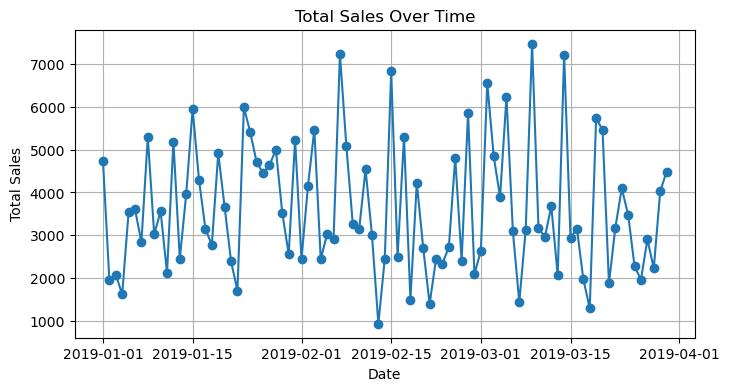

In [7]:
# Plot the total sales over time
plt.figure(figsize=(8, 4))
plt.plot(sales_by_date['date'], sales_by_date['total'], marker='o')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

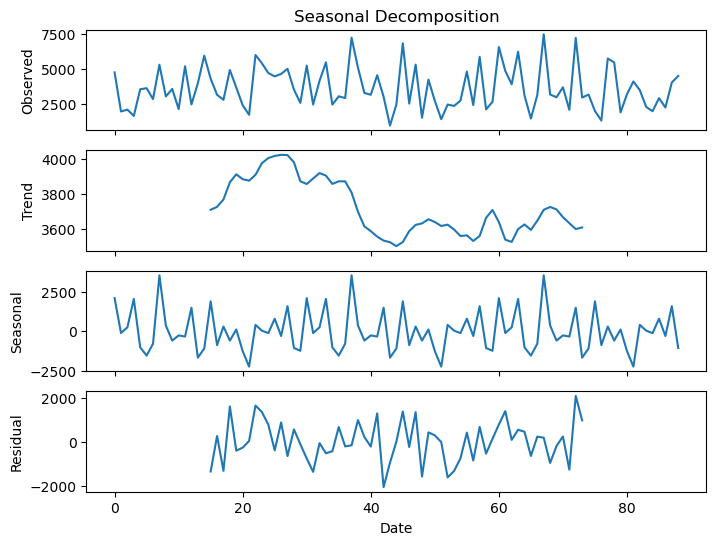

In [8]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_by_date['total'], model='additive', period=30)

# Plot the decomposition results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 6), sharex=True)

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax1.set_title('Seasonal Decomposition')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residual')
ax4.set_xlabel('Date')

plt.show()

### corrleation heatmap

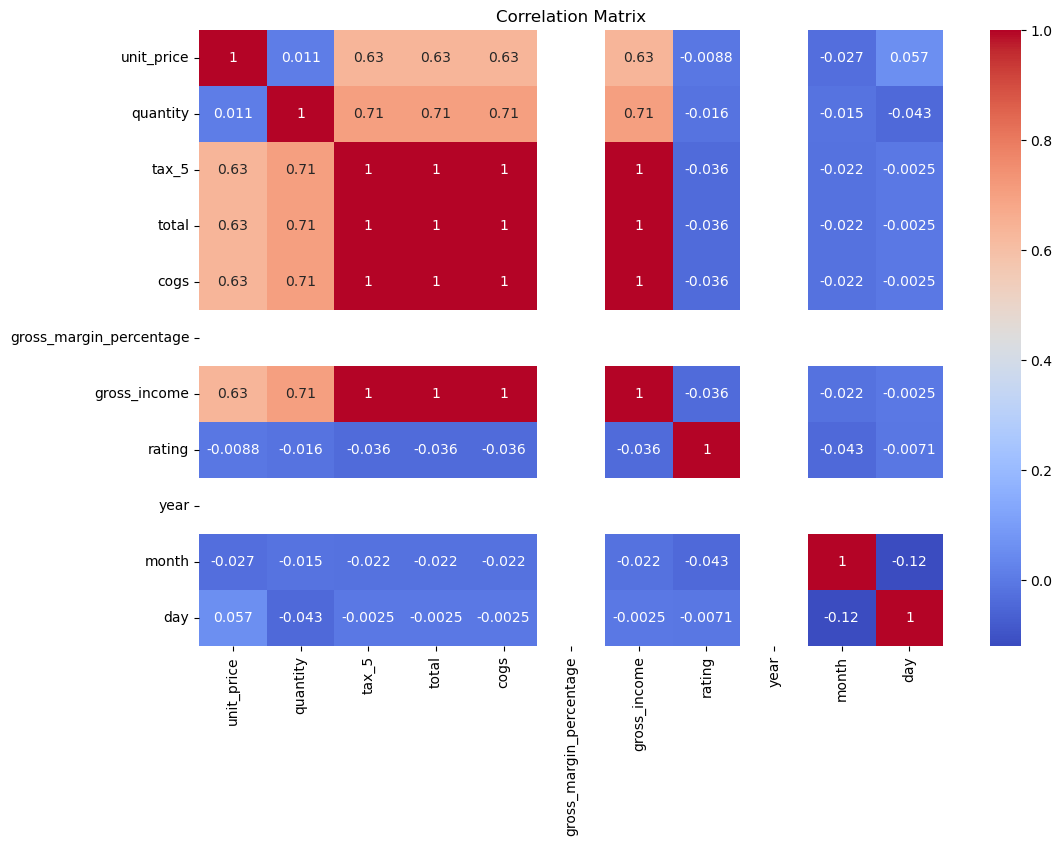

In [9]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### 4 Data Preprocessing and Feature Engineering


In [10]:

# Encode the branch column
label_encoder = LabelEncoder()
df1['branch_encoded'] = label_encoder.fit_transform(df1['branch'])
df1 = df1.drop(columns=['branch'])
df1


,date,unit_price,quantity,rating,day,month,year,total,branch_encoded
856,2019-01-01,21.12,8,6.3,1,1,2019,177.408,1
567,2019-01-01,65.74,9,7.7,1,1,2019,621.243,0
245,2019-01-01,47.59,8,5.7,1,1,2019,399.756,0
696,2019-01-01,27.04,4,6.9,1,1,2019,113.568,0
523,2019-01-01,62.87,2,5.0,1,1,2019,132.027,2
...,...,...,...,...,...,...,...,...,...
158,2019-03-30,97.22,9,6.0,30,3,2019,918.729,1
881,2019-03-30,10.18,8,9.5,30,3,2019,85.512,2
963,2019-03-30,96.82,3,6.7,30,3,2019,304.983,2
937,2019-03-30,89.48,5,7.4,30,3,2019,469.770,0


In [12]:
# Create separate DataFrames for each branch
branch_a_df = df1[df1['branch_encoded'] == label_encoder.transform(['A'])[0]]
branch_b_df = df1[df1['branch_encoded'] == label_encoder.transform(['B'])[0]]
branch_c_df = df1[df1['branch_encoded'] == label_encoder.transform(['C'])[0]]


In [78]:
branch_a_df

,date,unit_price,quantity,rating,day,month,year,total,branch_encoded
567,2019-01-01,65.74,9,7.7,1,1,2019,621.2430,0
245,2019-01-01,47.59,8,5.7,1,1,2019,399.7560,0
696,2019-01-01,27.04,4,6.9,1,1,2019,113.5680,0
829,2019-01-01,74.22,10,4.3,1,1,2019,779.3100,0
17,2019-01-01,72.61,6,6.9,1,1,2019,457.4430,0
...,...,...,...,...,...,...,...,...,...
14,2019-03-29,71.38,10,5.7,29,3,2019,749.4900,0
306,2019-03-30,40.23,7,9.6,30,3,2019,295.6905,0
883,2019-03-30,34.42,6,7.5,30,3,2019,216.8460,0
937,2019-03-30,89.48,5,7.4,30,3,2019,469.7700,0


In [79]:
# Aggregate data for branch A
branch_a_agg = branch_a_df.groupby('date').agg({
    'unit_price': 'mean',
    'quantity': 'sum',
    'rating': 'mean',
    'day': 'first',
    'month': 'first',
    'year': 'first',
    'total': 'sum'
}).reset_index()

# Aggregate data for branch B
branch_b_agg = branch_b_df.groupby('date').agg({
    'unit_price': 'mean',
    'quantity': 'sum',
    'rating': 'mean',
    'day': 'first',
    'month': 'first',
    'year': 'first',
    'total': 'sum'
}).reset_index()

# Aggregate data for branch C
branch_c_agg = branch_c_df.groupby('date').agg({
    'unit_price': 'mean',
    'quantity': 'sum',
    'rating': 'mean',
    'day': 'first',
    'month': 'first',
    'year': 'first',
    'total': 'sum'
}).reset_index()


In [81]:
branch_a_agg.to_csv('branch_a_agg.csv')

In [82]:
branch_b_agg.to_csv('branch_b_agg.csv')

In [83]:
branch_c_agg.to_csv('branch_c_agg.csv')

#### 5. Modeling


In [29]:
# Ensure date ordering
branch_a_agg = branch_a_agg.sort_values(by='date')
branch_b_agg = branch_b_agg.sort_values(by='date')
branch_c_agg = branch_c_agg.sort_values(by='date')

In [32]:
# Define models
models = {
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'KNN': KNeighborsRegressor(),
    'XGBoost': XGBRegressor(),
    'LightGBM': LGBMRegressor(),
    'CatBoost': CatBoostRegressor(silent=True)  # silent=True to suppress output during training
}

#### train the models 

In [50]:

# Function to prepare data
def train_and_evaluate(branch_df, branch_name):
    results = {}
    X = branch_df[['unit_price', 'quantity', 'rating', 'day', 'month', 'year']]
    y = branch_df['total']
    
    tscv = TimeSeriesSplit(n_splits=5)
    
    for model_name, model in models.items():
        mae_scores = []
        mse_scores = []
        
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            mae_scores.append(mean_absolute_error(y_test, y_pred))
            mse_scores.append(mean_squared_error(y_test, y_pred))
        
        results[model_name] = {
            'MAE': np.mean(mae_scores),
            'MSE': np.mean(mse_scores)
        }
    
    return pd.DataFrame(results).T

#### evaluate the models 

In [51]:
# Evaluate models for each branch
branch_a_results = train_and_evaluate(branch_a_agg, 'Branch A')
branch_b_results = train_and_evaluate(branch_b_agg, 'Branch B')
branch_c_results = train_and_evaluate(branch_c_agg, 'Branch C')


In [52]:
branch_a_results

,MAE,MSE
DecisionTree,303.682650,161175.188464
RandomForest,215.188993,84858.618047
GradientBoosting,220.159810,86678.249125
KNN,307.355400,151366.188415
XGBoost,224.967039,79920.296210
LightGBM,439.175480,321253.587277
CatBoost,305.468898,152902.052786


In [53]:
branch_b_results

,MAE,MSE
DecisionTree,337.168650,209404.446210
RandomForest,273.408000,151727.516025
GradientBoosting,241.690137,140803.091913
KNN,327.650580,182790.519131
XGBoost,238.402971,111515.657799
LightGBM,498.623211,496367.250924
CatBoost,381.195455,231004.641739


In [54]:
branch_c_results

,MAE,MSE
DecisionTree,344.528700,225236.939546
RandomForest,255.888000,105890.729032
GradientBoosting,238.287007,109851.076250
KNN,279.732390,142845.131359
XGBoost,283.859626,133740.708264
LightGBM,450.179635,361462.483784
CatBoost,277.377900,150727.678998


### Select the Best Model

In [57]:
# Function to select the best model based on evaluation metrics
def select_best_model(evaluation_results):
    best_model = evaluation_results.loc[evaluation_results['MAE'].idxmin()].name
    return best_model
# Select the best model for each branch
best_model_a_name = select_best_model(branch_a_results)
best_model_b_name = select_best_model(branch_b_results)
best_model_c_name = select_best_model(branch_c_results)

In [58]:
best_model_a_name, best_model_b_name, best_model_c_name

('RandomForest', 'XGBoost', 'GradientBoosting')

### Predict Future Sales


In [59]:
# Initialize the best models based on the selected names
best_model_a = models[best_model_a_name]
best_model_b = models[best_model_b_name]
best_model_c = models[best_model_c_name]

# Function to predict future sales using the best model
def predict_future_sales(branch_df, best_model):
    X = branch_df[['unit_price', 'quantity', 'rating', 'day', 'month', 'year']]
    y = branch_df['total']
    
    # Train the best model on the entire dataset
    best_model.fit(X, y)
    
    # Generate future dates and features
    last_date = branch_df['date'].max()
    future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 8)]
    future_features = pd.DataFrame({
        'unit_price': X['unit_price'].mean(),  # Assuming mean values; adjust if needed
        'quantity': X['quantity'].mean(),
        'rating': X['rating'].mean(),
        'day': [d.day for d in future_dates],
        'month': [d.month for d in future_dates],
        'year': [d.year for d in future_dates],
    }, index=future_dates)
    
    # Predict future sales
    future_preds = best_model.predict(future_features)
    
    return pd.DataFrame({'date': future_dates, 'predicted_total_sales': future_preds})


In [60]:
# Predict future sales for each branch
branch_a_future_predictions = predict_future_sales(branch_a_agg, best_model_a)
branch_b_future_predictions = predict_future_sales(branch_b_agg, best_model_b)
branch_c_future_predictions = predict_future_sales(branch_c_agg, best_model_c)

In [61]:
branch_a_future_predictions, branch_b_future_predictions, branch_c_future_predictions


(        date  predicted_total_sales
 0 2019-03-31            1162.823340
 1 2019-04-01            1167.958365
 2 2019-04-02            1167.958365
 3 2019-04-03            1168.411230
 4 2019-04-04            1171.431030
 5 2019-04-05            1171.431030
 6 2019-04-06            1165.660755,
         date  predicted_total_sales
 0 2019-03-31            1130.454590
 1 2019-04-01            1105.018311
 2 2019-04-02            1102.992554
 3 2019-04-03            1102.984497
 4 2019-04-04            1129.675171
 5 2019-04-05            1129.675171
 6 2019-04-06            1141.615845,
         date  predicted_total_sales
 0 2019-03-31            1411.400827
 1 2019-04-01            1502.364458
 2 2019-04-02            1502.364458
 3 2019-04-03            1507.430173
 4 2019-04-04            1507.430173
 5 2019-04-05            1507.430173
 6 2019-04-06            1507.430173)

In [74]:
# Combine future predictions for all branches into one DataFrame with separate columns
def combine_predictions_as_columns(branch_a_preds, branch_b_preds, branch_c_preds):
    combined = branch_a_preds.copy().drop(columns=['branch'])
    combined = combined.rename(columns={'predicted_total_sales': 'Branch_A_sales'})
    combined['Branch_B_sales'] = branch_b_preds['predicted_total_sales'].values
    combined['Branch_C_sales'] = branch_c_preds['predicted_total_sales'].values
    return combined

# Combine the predictions
all_future_predictions = combine_predictions_as_columns(branch_a_future_predictions, branch_b_future_predictions, branch_c_future_predictions)

all_future_predictions.to_csv('future_predictioins_mustafa.csv')

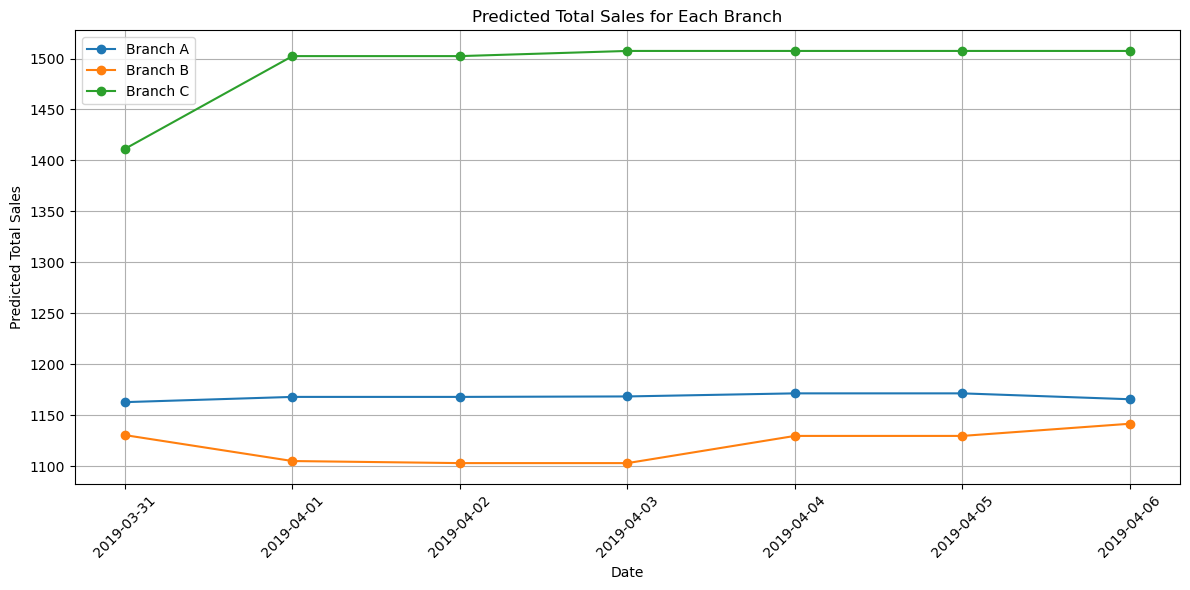

In [67]:
import matplotlib.pyplot as plt

# Plot the predicted sales for each branch
def plot_predictions(predictions_df):
    plt.figure(figsize=(12, 6))

    plt.plot(predictions_df['date'], predictions_df['Branch_A_sales'], marker='o', label='Branch A')
    plt.plot(predictions_df['date'], predictions_df['Branch_B_sales'], marker='o', label='Branch B')
    plt.plot(predictions_df['date'], predictions_df['Branch_C_sales'], marker='o', label='Branch C')

    plt.xlabel('Date')
    plt.ylabel('Predicted Total Sales')
    plt.title('Predicted Total Sales for Each Branch')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.show()

# Visualize the results
plot_predictions(all_future_predictions)


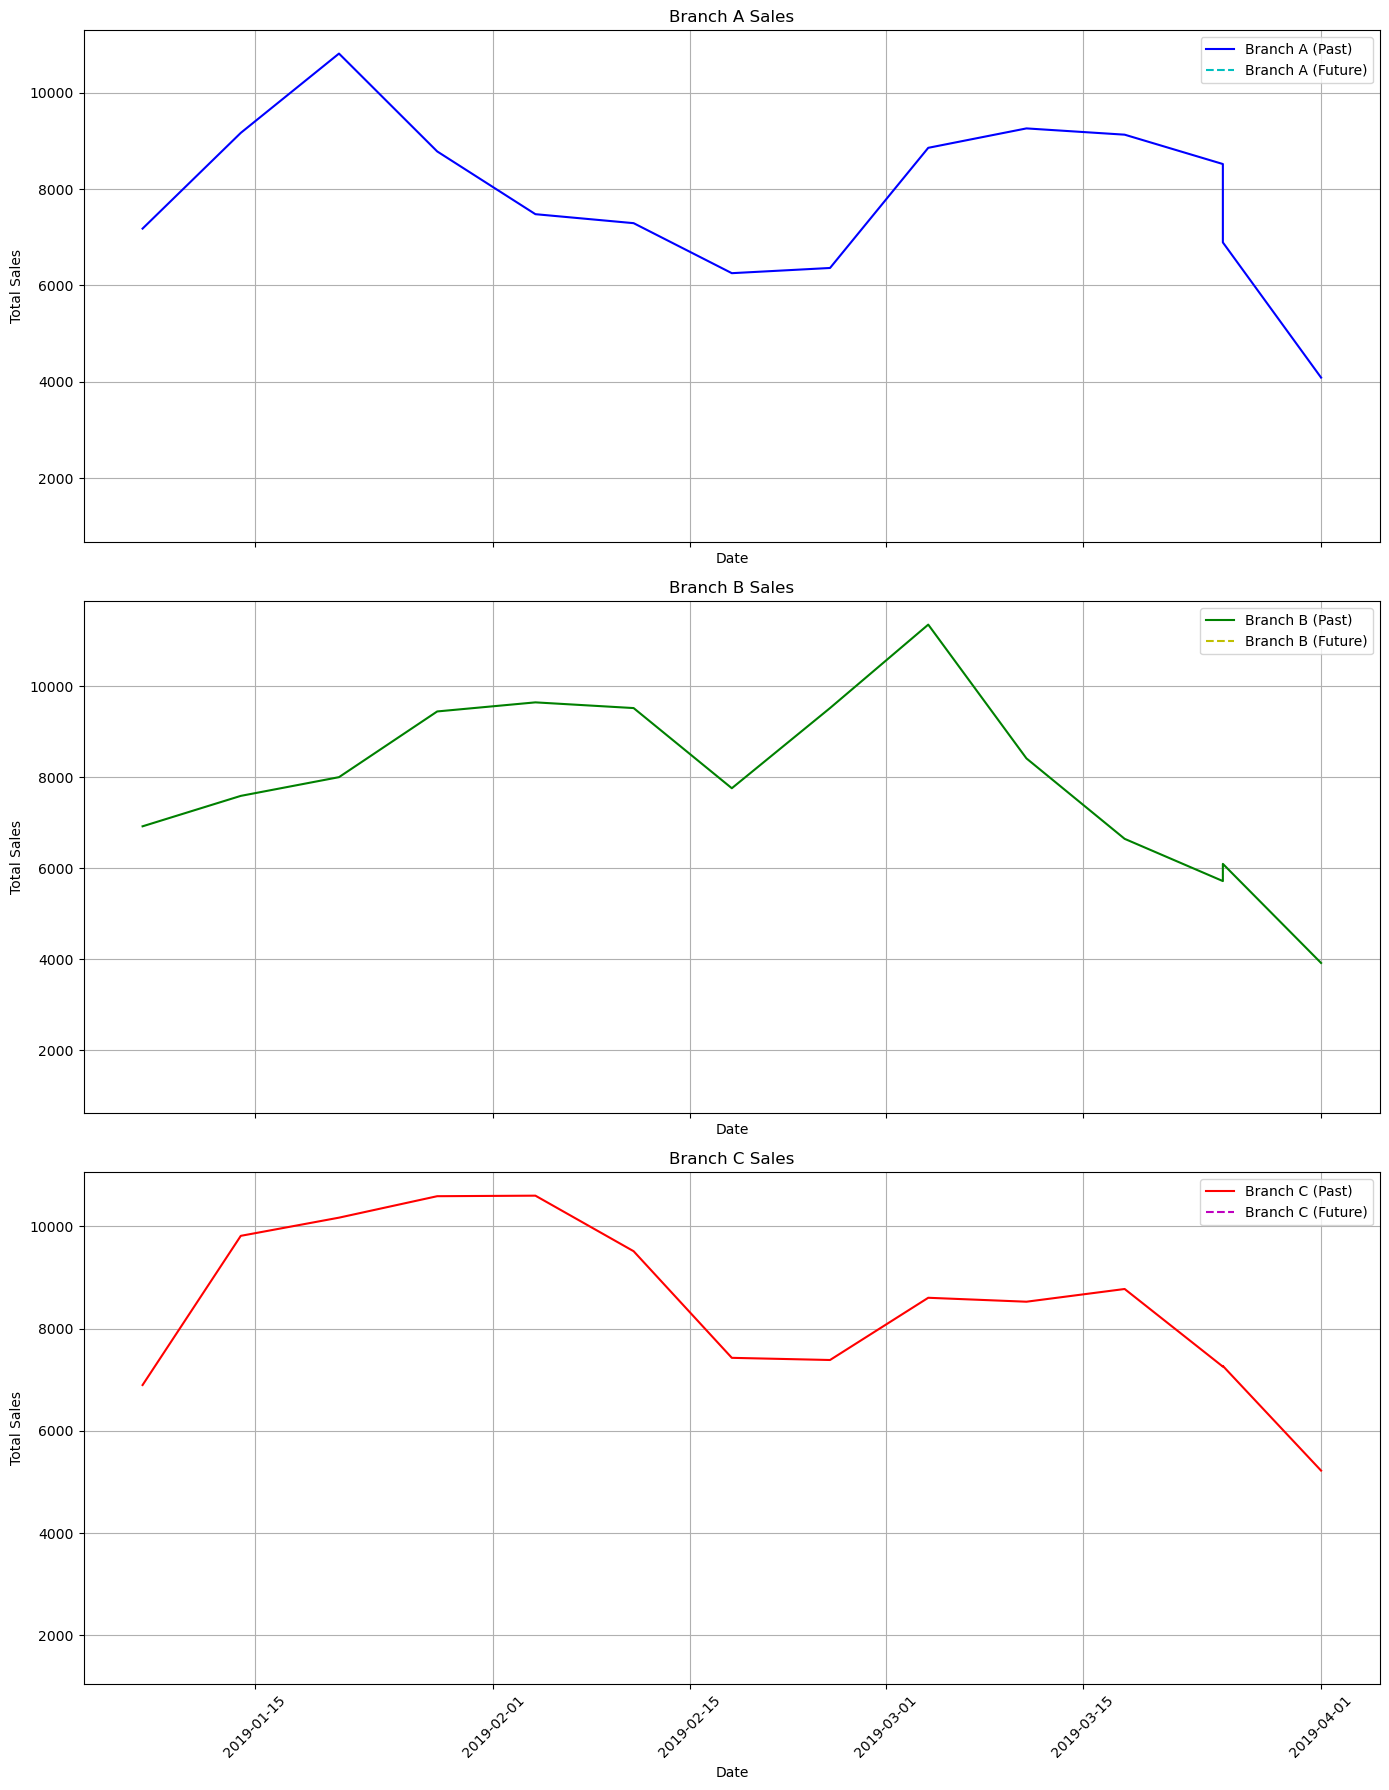

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare historical sales data for each branch, aggregated by week
def prepare_historical_data(branch_df):
    branch_df['week'] = branch_df['date'].dt.to_period('W').apply(lambda r: r.start_time)
    historical_data = branch_df.groupby('week')['total'].sum().reset_index()
    historical_data = historical_data.rename(columns={'week': 'date', 'total': 'sales'})
    return historical_data

# Historical sales data for each branch
historical_sales_a = prepare_historical_data(branch_a_agg)
historical_sales_b = prepare_historical_data(branch_b_agg)
historical_sales_c = prepare_historical_data(branch_c_agg)

# Generate future dates
last_date = historical_sales_a['date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7)

# Combine historical and future predictions, aggregated by week
def combine_historical_and_future(historical_df, future_df, branch_name):
    future_df['date'] = future_dates
    future_df = future_df.rename(columns={'predicted_total_sales': 'sales'})
    future_df = future_df.groupby(future_df['date'].dt.to_period('W').apply(lambda r: r.start_time)).sum().reset_index()
    combined_df = pd.concat([historical_df, future_df], ignore_index=True)
    combined_df['branch'] = branch_name
    return combined_df

# Combine the predictions with historical data
combined_sales_a = combine_historical_and_future(historical_sales_a, branch_a_future_predictions, 'A')
combined_sales_b = combine_historical_and_future(historical_sales_b, branch_b_future_predictions, 'B')
combined_sales_c = combine_historical_and_future(historical_sales_c, branch_c_future_predictions, 'C')

# Plot past and future sales for each branch in separate subplots with smoother lines
def plot_past_and_future_sales(combined_sales_a, combined_sales_b, combined_sales_c):
    fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

    # Plot Branch A sales
    axes[0].plot(combined_sales_a['date'], combined_sales_a['sales'].rolling(window=2).mean(), 'b-', label='Branch A (Past)')
    axes[0].plot(combined_sales_a[combined_sales_a['date'] > historical_sales_a['date'].max()]['date'],
                 combined_sales_a[combined_sales_a['date'] > historical_sales_a['date'].max()]['sales'], 'c--', label='Branch A (Future)')
    axes[0].set_title('Branch A Sales')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Branch B sales
    axes[1].plot(combined_sales_b['date'], combined_sales_b['sales'].rolling(window=2).mean(), 'g-', label='Branch B (Past)')
    axes[1].plot(combined_sales_b[combined_sales_b['date'] > historical_sales_b['date'].max()]['date'],
                 combined_sales_b[combined_sales_b['date'] > historical_sales_b['date'].max()]['sales'], 'y--', label='Branch B (Future)')
    axes[1].set_title('Branch B Sales')
    axes[1].legend()
    axes[1].grid(True)

    # Plot Branch C sales
    axes[2].plot(combined_sales_c['date'], combined_sales_c['sales'].rolling(window=2).mean(), 'r-', label='Branch C (Past)')
    axes[2].plot(combined_sales_c[combined_sales_c['date'] > historical_sales_c['date'].max()]['date'],
                 combined_sales_c[combined_sales_c['date'] > historical_sales_c['date'].max()]['sales'], 'm--', label='Branch C (Future)')
    axes[2].set_title('Branch C Sales')
    axes[2].legend()
    axes[2].grid(True)

    for ax in axes:
        ax.set_xlabel('Date')
        ax.set_ylabel('Total Sales')
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Visualize the past and future sales
plot_past_and_future_sales(combined_sales_a, combined_sales_b, combined_sales_c)


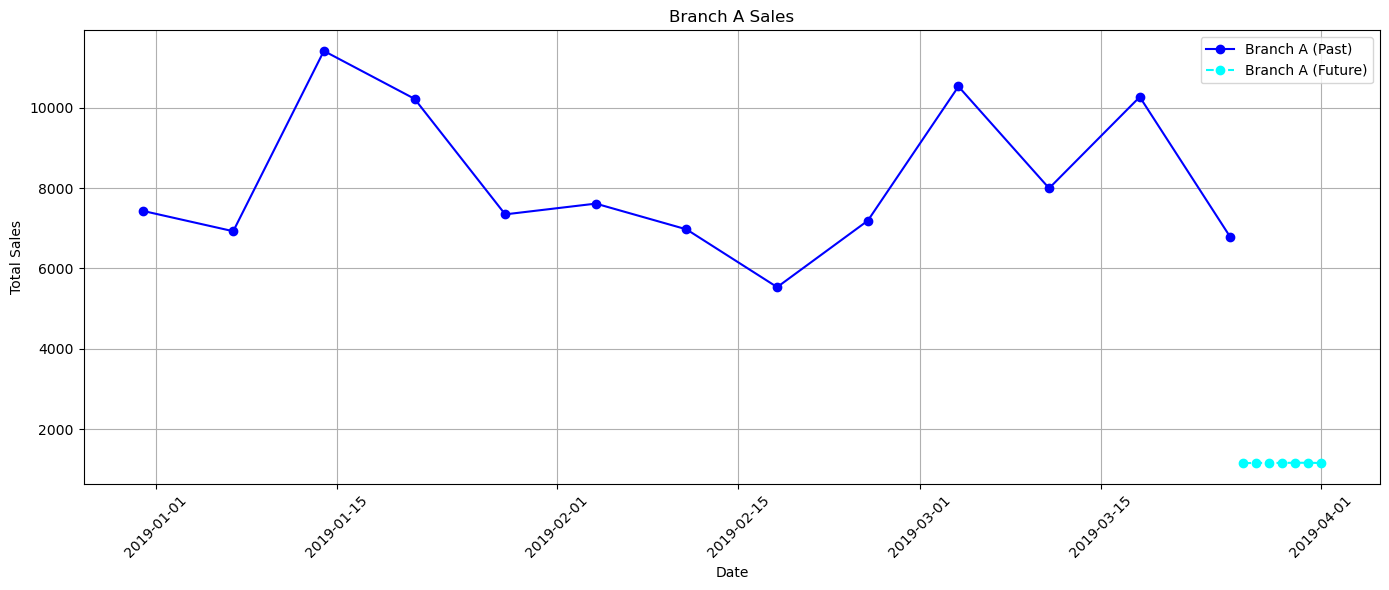

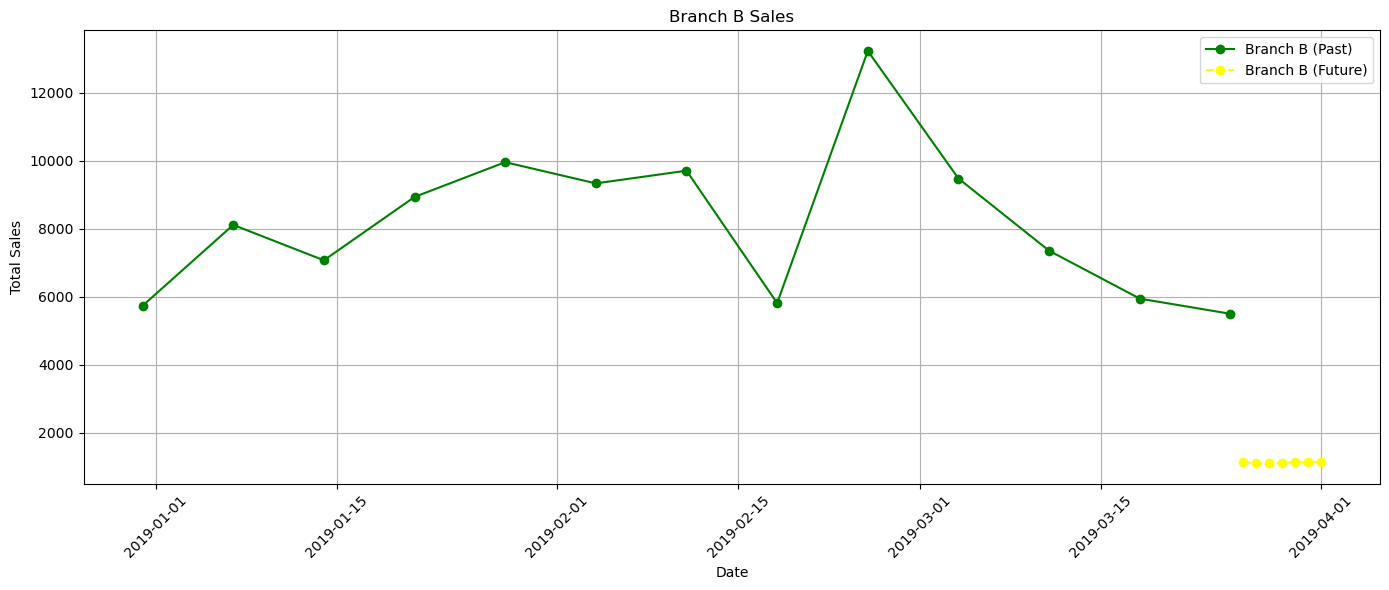

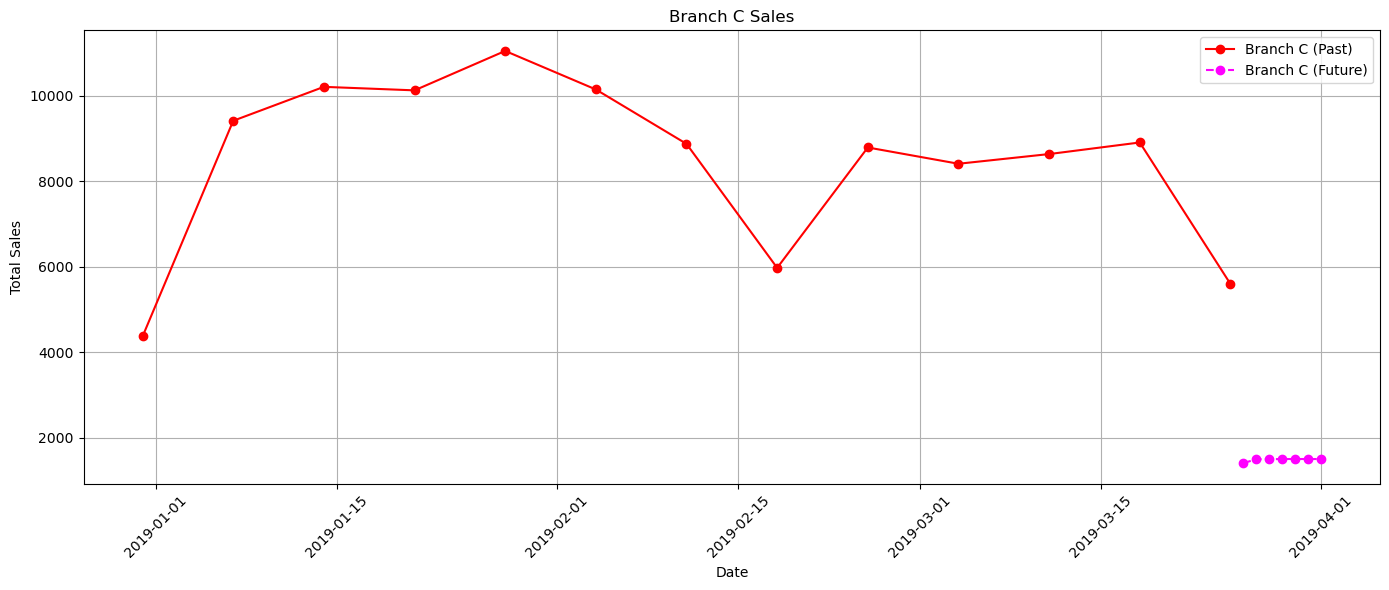

In [85]:
import pandas as pd
import matplotlib.pyplot as plt



# Convert the 'date' columns to datetime
all_future_predictions['date'] = pd.to_datetime(all_future_predictions['date'])
branch_a_agg['date'] = pd.to_datetime(branch_a_agg['date'])
branch_b_agg['date'] = pd.to_datetime(branch_b_agg['date'])
branch_c_agg['date'] = pd.to_datetime(branch_c_agg['date'])

# Prepare historical sales data for each branch, aggregated by week
def prepare_historical_data(branch_df):
    branch_df['week'] = branch_df['date'].dt.to_period('W').apply(lambda r: r.start_time)
    historical_data = branch_df.groupby('week')['total'].sum().reset_index()
    historical_data = historical_data.rename(columns={'week': 'date', 'total': 'sales'})
    return historical_data

# Historical sales data for each branch
historical_sales_a = prepare_historical_data(branch_a_agg)
historical_sales_b = prepare_historical_data(branch_b_agg)
historical_sales_c = prepare_historical_data(branch_c_agg)

# Prepare future sales data for each branch
future_sales_a = all_future_predictions[['date', 'Branch_A_sales']].rename(columns={'Branch_A_sales': 'sales'})
future_sales_b = all_future_predictions[['date', 'Branch_B_sales']].rename(columns={'Branch_B_sales': 'sales'})
future_sales_c = all_future_predictions[['date', 'Branch_C_sales']].rename(columns={'Branch_C_sales': 'sales'})

# Plot past and future sales for each branch in separate subplots with smoother lines
def plot_past_and_future_sales(historical_sales, future_sales, branch_name, color_past, color_future):
    plt.figure(figsize=(14, 6))
    
    # Plot historical sales
    plt.plot(historical_sales['date'], historical_sales['sales'], color=color_past, label=f'Branch {branch_name} (Past)', marker='o')
    
    # Plot future sales
    plt.plot(future_sales['date'], future_sales['sales'], color=color_future, label=f'Branch {branch_name} (Future)', linestyle='--', marker='o')

    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.title(f'Branch {branch_name} Sales')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualize the past and future sales for each branch
plot_past_and_future_sales(historical_sales_a, future_sales_a, 'A', 'blue', 'cyan')
plot_past_and_future_sales(historical_sales_b, future_sales_b, 'B', 'green', 'yellow')
plot_past_and_future_sales(historical_sales_c, future_sales_c, 'C', 'red', 'magenta')


### 6 Hyperparameter Tuning for the Best Model


### Hypertunning the best model 

In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Define the best features based on the best-performing model
best_features = ['year', 'month', 'day', 'dayofweek'] + list(relevant_columns[relevant_columns.str.contains('gender_city')])
X = sales_by_date[best_features]
y = sales_by_date['total']

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define hyperparameters for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100]
}

lgb = LGBMRegressor()
grid_search = GridSearchCV(estimator=lgb, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=5), n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

# Predict using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Final evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Final MSE: {mse}')
print(f'Final MAE: {mae}')
print(f'Final R2: {r2}')


Best parameters found:  {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 100, 'num_leaves': 31}
Best score:  2308139.120328372
Final MSE: 939945.6867988987
Final MAE: 804.6061154729301
Final R2: 0.5983868839549669


### 7 Predict Future Sales


#### Predictions based only on time series 

In [ ]:
# Define the best features including the encoded categorical values
best_features = ['year', 'month', 'day', 'dayofweek'] + list(relevant_columns)

# Ensure the columns in sales_by_date match the columns used in best_features
missing_cols = set(best_features) - set(sales_by_date.columns)
for col in missing_cols:
    sales_by_date[col] = 0

# Reorder sales_by_date to match the order of best_features
sales_by_date = sales_by_date[['date'] + best_features + ['total']]

# Prepare training data
X = sales_by_date[best_features]
y = sales_by_date['total']

# Create the best model using the best parameters found
best_model = LGBMRegressor(
    learning_rate=0.1,
    max_depth=None,
    n_estimators=100,
    num_leaves=31
)

# Train the model on the entire dataset
best_model.fit(X, y)




LGBMRegressor(max_depth=None)

In [ ]:
# Generate the next 7 days of dates
last_date = sales_by_date['date'].max()
future_dates = pd.date_range(start=last_date, periods=8, closed='right')

# Prepare the feature set for future dates based only on time-related features
future_data_time_only = pd.DataFrame({
    'date': future_dates,
    'year': future_dates.year,
    'month': future_dates.month,
    'day': future_dates.day,
    'dayofweek': future_dates.dayofweek
})

# Add placeholder columns for the encoded categorical features
for col in relevant_columns:
    future_data_time_only[col] = 0

# Ensure the columns in future_data_time_only match the columns used in best_features
future_data_time_only = future_data_time_only[best_features]

# Predict future sales using time-related features
X_future_time_only = future_data_time_only[best_features]
future_sales_predictions_time_only = best_model.predict(X_future_time_only)

# Display the future sales predictions based only on time-related features
future_sales_time_only_df = pd.DataFrame({'date': future_dates, 'predicted_sales': future_sales_predictions_time_only})
print("Future sales predictions based only on time-related features:")
print(future_sales_time_only_df)


Future sales predictions based only on time-related features:
        date  predicted_sales
0 2019-03-31       981.244838
1 2019-04-01       651.768896
2 2019-04-02       651.768896
3 2019-04-03       651.768896
4 2019-04-04       717.931386
5 2019-04-05       753.052760
6 2019-04-06       753.052760
